1. Student Name: Vishal
1. Student Id: n01676081

In [1]:
import zipfile
with zipfile.ZipFile('Assign01.zip', 'r') as f:
  f.extractall()

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')
from IPython import display
import seaborn as sn
from sklearn.metrics import confusion_matrix,f1_score,precision_score, recall_score, accuracy_score, ConfusionMatrixDisplay
import pandas as pd

In [3]:
#check GPU availabilty
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## load data

In [4]:
test_file = 'Assign/mitbih_test.csv'
train_file = 'Assign/mitbih_train.csv'

test_data = np.loadtxt(test_file,delimiter=',',skiprows=1)
train_data = np.loadtxt(train_file,delimiter=',',skiprows=1)
print(train_data.shape)
print(test_data.shape)

(87553, 188)
(21891, 188)


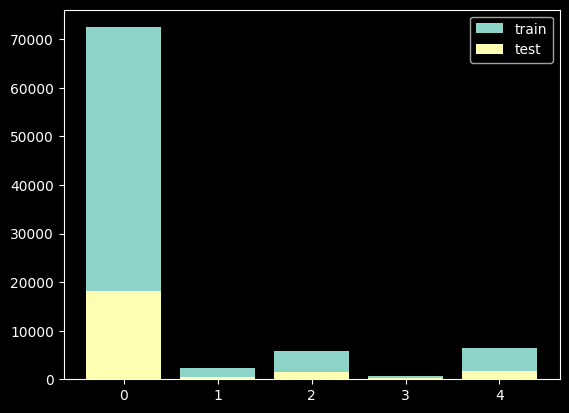

In [5]:
train_labels, train_label_counts = np.unique(train_data[:, -1], return_counts=True)
test_labels, test_label_counts = np.unique(test_data[:, -1], return_counts=True)

#visualize class balance
plt.bar(train_labels, train_label_counts, label='train')
plt.bar(test_labels, test_label_counts, label='test')
plt.legend()
plt.show()

## Transform to Tensor and Using DataLoader

In [6]:
X_train = train_data[:,:-1].copy()
y_train = train_data[:,-1].copy()
X_test = test_data[:,:-1].copy()
y_test = test_data[:,-1].copy()

# Step1: Convert to tensor
train_data = torch.tensor(X_train, dtype = torch.float32 )
train_labels = torch.tensor(y_train, dtype = torch.long)
test_data = torch.tensor(X_test, dtype = torch.float32 )
test_labels = torch.tensor(y_test, dtype = torch.long)

# Step2: Convert to PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step3: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=batchsize, drop_last=True)

## ANN Architecture

In [18]:
model = nn.Sequential(
    nn.Linear(187, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.BatchNorm1d(64),
    nn.Linear(64, 5),
)

model

Sequential(
  (0): Linear(in_features=187, out_features=256, bias=True)
  (1): ReLU()
  (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Linear(in_features=128, out_features=64, bias=True)
  (7): ReLU()
  (8): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Linear(in_features=64, out_features=5, bias=True)
)

### Learning Loop

In [19]:
%%time

epochs = 32
lr = 0.001
lossfunc = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr = lr)

model.to(device) # placing a model on GPU

# Initialize losses and Accuracies
losses    = torch.zeros(epochs)
trainAcc  = []
testAcc   = []


# For Loop for epochs
for epoch in range(epochs):
 model.train()
 # Loop for training in batches

 batchAcc  = []
 batchLoss = []

 for X,y in train_loader:
    X = X.to(device) # Placing features on device
    y = y.to(device) # placing labels on device

    ypred = model(X)
    loss = lossfunc(ypred,y)

    # Backpropagation
    optimizer.zero_grad() #reseting gradients
    loss.backward() #back propagation
    optimizer.step() #adjusting weights

    # Append batchloss
    batchLoss.append(loss.item())
    ypred = ypred.cpu() # Back to cpu
    y = y.cpu()

    # compute batch accuracy
    acc = 100 * torch.mean((torch.argmax(ypred, dim=1) == y).float())
    batchAcc.append(acc)

  # Batch loop concluded
  # Average training accuracy (Outside the batchloop)
 trainAcc.append(np.mean(batchAcc))

  # Losses through epochs
 losses[epoch] = np.mean(batchLoss)

 # TESTING the model
 model.eval()
 X,y = next(iter(test_loader))
 X = X.to(device)
 y = y.to(device)

 with torch.no_grad(): #This step  Deactivating autogradient
    ypred = model(X)
    ypred = ypred.cpu()
    y = y.cpu()

  # Appending test accuracy
    testAcc.append(100 * torch.mean((torch.argmax(ypred,dim=1)==y).float()))
    if (epoch % 5) == 0:
          print(f' epochs : {epoch}  loss : {loss : 3.2f}')

 epochs : 0  loss :  0.24
 epochs : 5  loss :  0.03
 epochs : 10  loss :  0.01
 epochs : 15  loss :  0.04
 epochs : 20  loss :  0.01
 epochs : 25  loss :  0.01
 epochs : 30  loss :  0.01
CPU times: user 3min 46s, sys: 2.87 s, total: 3min 49s
Wall time: 4min 17s


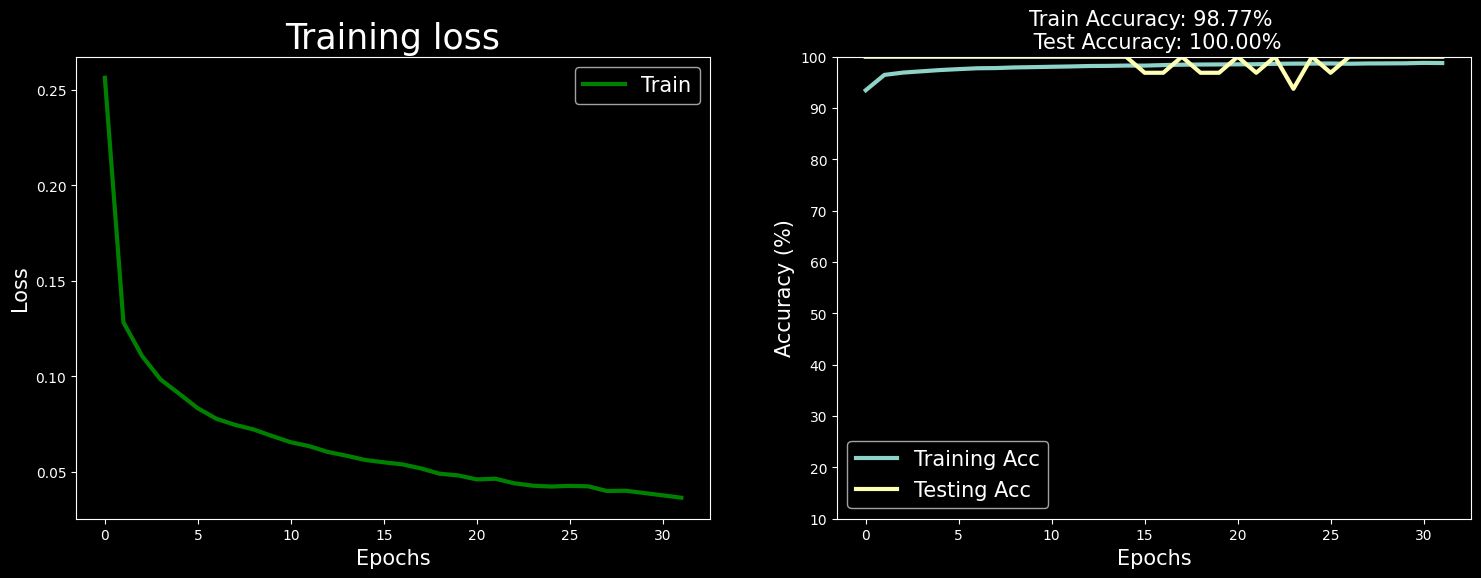

Params*
Epoch: 32
--------------------
Lr: 0.001
--------------------
 Model:
 Sequential(
  (0): Linear(in_features=187, out_features=256, bias=True)
  (1): ReLU()
  (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Linear(in_features=128, out_features=64, bias=True)
  (7): ReLU()
  (8): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Linear(in_features=64, out_features=5, bias=True)
)
--------------------
 Optimizer:
 SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)


In [26]:
fig,ax = plt.subplots(1,2,figsize=(18,6))

ax[0].plot(losses,'g', lw = 3)
ax[0].set_xlabel('Epochs', fontsize = 15)
ax[0].set_ylabel('Loss', fontsize = 15)
ax[0].legend(['Train','Test'], fontsize = 15)
ax[0].set_title('Training loss', fontsize = 25)

ax[1].plot(trainAcc,label='Training Acc', lw =3)
ax[1].plot(testAcc,label='Testing Acc', lw = 3)
ax[1].set_yticks(np.arange(0,110,10))
ax[1].set_xlabel('Epochs', fontsize = 15)
ax[1].set_ylabel('Accuracy (%)', fontsize = 15)
ax[1].set_ylim([10,100])
ax[1].set_title(f'Train Accuracy: {trainAcc[-1]:.2f}% \n Test Accuracy: {testAcc[-1]:.2f}%', fontsize = 15)
ax[1].legend(fontsize = 15)
plt.show()

#params
dash_line = "-"*20
print(f'Params*\nEpoch: {epochs}\n{dash_line}\nLr: {lr}\n{dash_line}\n Model:\n {model}\n{dash_line}\n Optimizer:\n {optimizer}')
